In [1]:
import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Exploratory Data Analysis

In [2]:
# Read the dataset
df = pd.read_csv('./dataset/heart_failure.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
# Review the summary statistics of the training dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


# Partitioning

In [4]:
# Partition the dataset into training and testing datasets
X, y = df.drop('death_event', axis=1), df['death_event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((209, 12), (90, 12), (209,), (90,))

# Feature Transformation

In [5]:
# Check whether there are non-numeric features in the training dataset
non_numeric_features = X_train.select_dtypes(exclude='number').columns.tolist()
if len(non_numeric_features) == 0:
    print("There are no non-numeric features in the dataset.")

There are no non-numeric features in the dataset.


In [6]:
# Create a column transformer to impute missing values and normalize the data
col_transformation_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

all_columns = X_train.columns.tolist()

columns_transformer = ColumnTransformer(transformers=[
    ('cols', col_transformation_pipeline, all_columns),
])

# Model Training & Evaluation

In [7]:
''' 
Define the steps in the training pipeline: 
1) preprocessing with the column transformer
2) fit the trainig data with the random forest classifier
'''
rf_classifier = RandomForestClassifier(n_estimators = 11, criterion='entropy', random_state=0)

rf_model_pipeline = Pipeline(steps=[
    ('preprocessing', columns_transformer),
    ('rf_model', rf_classifier),
])

rf_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cols',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['age', 'anaemia',
                                                   'creatinine_phosphokinase',
                                                   'diabetes',
                                                   'ejection_fraction',
                                                   'high_blood_pressure',
                                                   'platelets',
                                                   'serum_creatinine',
                                                   'serum_sodium', 'sex',
                  

In [8]:
# Score the testing data using the random forrest model
y_pred = rf_model_pipeline.predict(X_test)

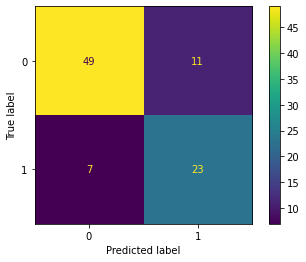

In [9]:
# Calculae the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.84        60
           1       0.68      0.77      0.72        30

    accuracy                           0.80        90
   macro avg       0.78      0.79      0.78        90
weighted avg       0.81      0.80      0.80        90



# Hyperparameter Tuning

In [11]:
'''
Tune hyperparameters using grid search:
1) n_estimators: The number of trees in random forest,
2) criterion: The function to measure the quality of a split,
3) max_depth : The maximum depth of the tree.
'''
params_dict = {
    'rf_model__n_estimators' : np.arange(5, 10, 1), 
    'rf_model__criterion': ['gini', 'entropy'], 
    'rf_model__max_depth': np.arange(10, 20, 5)
}

random_forest_model = GridSearchCV(rf_model_pipeline, params_dict, cv=10, n_jobs=-1)
random_forest_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cols',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'anaemia',
                                                                          'creatinine_phosphokinase',
                                                                          'diabetes',
                                                                        

In [12]:
# Score the testing data using the tuned model
y_pred_new = random_forest_model.predict(X_test)

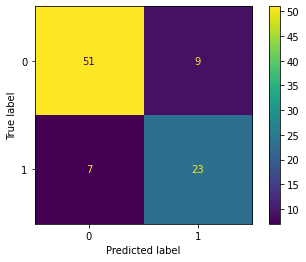

In [13]:
# Display confugison matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_new)

In [14]:
# Print out the classification report
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86        60
           1       0.72      0.77      0.74        30

    accuracy                           0.82        90
   macro avg       0.80      0.81      0.80        90
weighted avg       0.83      0.82      0.82        90



# Serialization

In [15]:
# Serialize and save the trained model
joblib.dump(random_forest_model, "random_forest_model.pkl")

['random_forest_model.pkl']

# Testing the Serialized Model

In [16]:
model = joblib.load("random_forest_model.pkl")

In [17]:
predictions = model.predict_proba(X_test)

In [18]:
predictions

array([[0.71428571, 0.28571429],
       [0.85714286, 0.14285714],
       [0.85714286, 0.14285714],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.85714286, 0.14285714],
       [0.42857143, 0.57142857],
       [0.71428571, 0.28571429],
       [0.85714286, 0.14285714],
       [1.        , 0.        ],
       [0.71428571, 0.28571429],
       [0.57142857, 0.42857143],
       [0.57142857, 0.42857143],
       [1.        , 0.        ],
       [0.14285714, 0.85714286],
       [0.28571429, 0.71428571],
       [1.        , 0.        ],
       [0.28571429, 0.71428571],
       [0.57142857, 0.42857143],
       [0.67857143, 0.32142857],
       [1.        , 0.        ],
       [0.9047619 , 0.0952381 ],
       [1.        , 0.        ],
       [0.42857143, 0.57142857],
       [1.        , 0.        ],
       [0.85714286, 0.14285714],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.